# Deeper look into synthetic SWE generation
## To see whether low-frequency oscillations are important

In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.formula.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy as sp
from scipy import stats as st
from scipy.stats import gamma, lognorm, multivariate_normal, norm, t
import seaborn as sbn
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'code/synthetic_data_and_moea_plots/')

### Project functions ###
import functions_clean_data
import functions_synthetic_data
import functions_revenues_contracts

sbn.set_style('white')
sbn.set_context('paper', font_scale=1.55)

cmap = cm.get_cmap('viridis')
col = [cmap(0.1),cmap(0.3),cmap(0.6),cmap(0.8)]

N_SAMPLES = 1000000
eps = 1e-13

dir_downloaded_inputs = './data/downloaded_inputs/'
dir_generated_inputs = './data/generated_inputs/'
dir_figs = './figures/'

In [2]:
### Get and clean data
# SWE
importlib.reload(functions_clean_data)
swe = functions_clean_data.get_clean_swe(dir_downloaded_inputs)[['danFeb','danApr']]

# gen
# gen = functions_clean_data.get_historical_generation(dir_downloaded_inputs, swe).reset_index()

#sweSynth 
sweSynth = functions_synthetic_data.synthetic_swe(dir_generated_inputs, swe, redo = True, save = False)

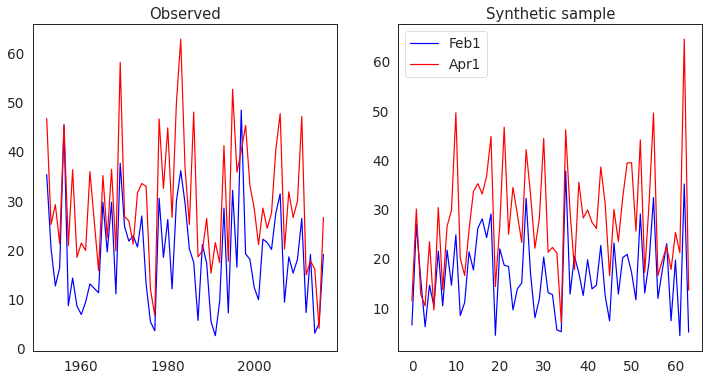

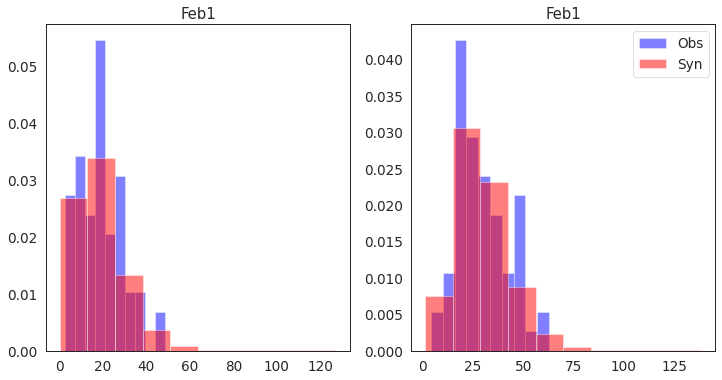

In [3]:
### Visually compare observations vs synthetic
cols = ['b','r']
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
plt.plot(swe.danFeb, c=cols[0])
plt.plot(swe.danApr, c=cols[1])
ax.set_title('Observed')
ax = plt.subplot(1,2,2)
plt.plot(sweSynth.danFeb[:64], c=cols[0])
plt.plot(sweSynth.danApr[:64], c=cols[1])
ax.set_title('Synthetic sample')
plt.legend(['Feb1','Apr1'])

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
plt.hist(swe.danFeb, color=cols[0], alpha=0.5, density=True)
plt.hist(sweSynth.danFeb, color=cols[1], alpha=0.5, density=True)
ax.set_title('Feb1')
ax = plt.subplot(1,2,2)
plt.hist(swe.danApr, color=cols[0], alpha=0.5, density=True)
plt.hist(sweSynth.danApr, color=cols[1], alpha=0.5, density=True)
ax.set_title('Feb1')
plt.legend(['Obs','Syn'])


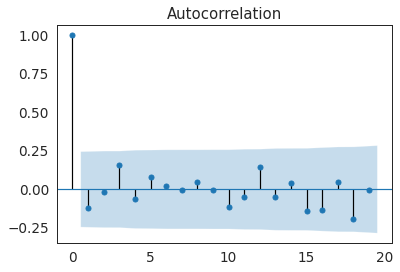

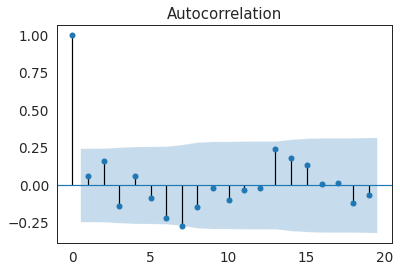

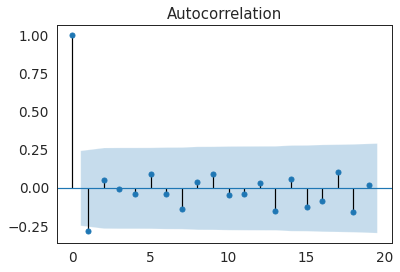

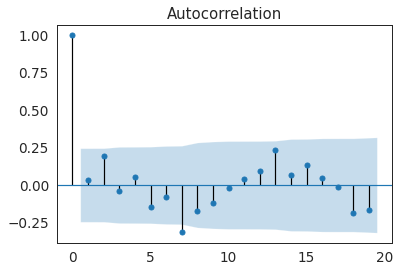

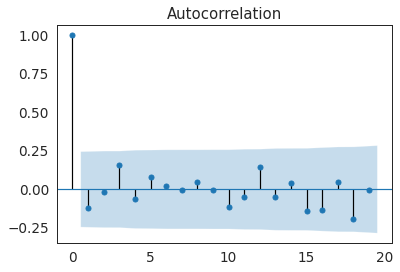

In [4]:
### Look at autocorrelation
plot_acf(swe.danFeb)
plot_acf(sweSynth[:64].danFeb)
plot_acf(swe.danApr)
plot_acf(sweSynth[:64].danApr)

In [28]:
### Exceedence curves for snowfall, with different moving avg windows
obsF = np.array(swe.danFeb.values)
obsA = np.array(swe.danApr.values)
syn = np.array([sweSynth.danFeb.values,sweSynth.danApr.values])
nyr = len(obsF)
nsyn = syn.shape[1]
nsamp = 1000

probs = {1: [n/(nyr+1) for n in range(nyr, 0, -1)],
          2: [n/(nyr) for n in range(nyr-1, 0, -1)],
          4: [n/(nyr-2) for n in range(nyr-3, 0, -1)],
          8: [n/(nyr-6) for n in range(nyr-7, 0, -1)],
          16: [n/(nyr-14) for n in range(nyr-15, 0, -1)]}

exceedence = {}
exceedence[1]  = {'obsF': [np.sort(obsF)], 'obsA': [np.sort(obsA)], 'synF':[], 'synA':[]}
exceedence[2]  = {'obsF': [np.sort((obsF[:-1] + obsF[1:])/2)], 'obsA': [np.sort((obsA[:-1] + obsA[1:])/2)], 'synF':[], 'synA':[]}
exceedence[4]  = {'obsF': [np.sort((obsF[:-3] + obsF[1:-2] + obsF[2:-1] + obsF[3:])/4)], 'synF':[], 'synA':[]}
exceedence[4]['obsA']  = [np.sort((obsA[:-3] + obsA[1:-2] + obsA[2:-1] + obsA[3:])/4)]
exceedence[8]  = {'obsF': [np.sort((obsF[:-7] + obsF[1:-6] + obsF[2:-5] + obsF[3:-4] + obsF[4:-3] + obsF[5:-2] + obsF[6:-1] + obsF[7:])/8)], 'synF':[], 'synA':[]}
exceedence[8]['obsA']  = [np.sort((obsA[:-7] + obsA[1:-6] + obsA[2:-5] + obsA[3:-4] + obsA[4:-3] + obsA[5:-2] + obsA[6:-1] + obsA[7:])/8)]
exceedence[16]  = {'obsF': [np.sort((obsF[:-15] + obsF[1:-14] + obsF[2:-13] + obsF[3:-12] + obsF[4:-11] + obsF[5:-10] + obsF[6:-9] + obsF[7:-8] + obsF[8:-7] + obsF[9:-6] + obsF[10:-5] + obsF[11:-4] + obsF[12:-3] + obsF[13:-2] + obsF[14:-1] + obsF[15:])/16)], 'synF':[], 'synA':[]}
exceedence[16]['obsA'] = [np.sort((obsA[:-15] + obsA[1:-14] + obsA[2:-13] + obsA[3:-12] + obsA[4:-11] + obsA[5:-10] + obsA[6:-9] + obsA[7:-8] + obsA[8:-7] + obsA[9:-6] + obsA[10:-5] + obsA[11:-4] + obsA[12:-3] + obsA[13:-2] + obsA[14:-1] + obsA[15:])/16)]

for i in range(nsamp):
    choice = np.random.choice(range(nsyn-nyr))
    dum = syn[:,choice:choice+nyr]
    exceedence[1]['synF'].append(np.sort(dum[0,:]))
    exceedence[1]['synA'].append(np.sort(dum[1,:]))

    exceedence[2]['synF'].append(np.sort((dum[0,:nyr-1] + dum[0,1:nyr])/2))
    exceedence[2]['synA'].append(np.sort((dum[1,:nyr-1] + dum[1,1:nyr])/2))

    exceedence[4]['synF'].append(np.sort((dum[0,:nyr-3] + dum[0,1:nyr-2] + dum[0,2:nyr-1] + dum[0,3:nyr])/4))
    exceedence[4]['synA'].append(np.sort((dum[1,:nyr-3] + dum[1,1:nyr-2] + dum[1,2:nyr-1] + dum[1,3:nyr])/4))

    exceedence[8]['synF'].append(np.sort((dum[0,:nyr-7] + dum[0,1:nyr-6] + dum[0,2:nyr-5] + dum[0,3:nyr-4] + dum[0,4:nyr-3] + dum[0,5:nyr-2] + dum[0,6:nyr-1] + dum[0,7:nyr])/8))
    exceedence[8]['synA'].append(np.sort((dum[1,:nyr-7] + dum[1,1:nyr-6] + dum[1,2:nyr-5] + dum[1,3:nyr-4] + dum[1,4:nyr-3] + dum[1,5:nyr-2] + dum[1,6:nyr-1] + dum[1,7:nyr])/8))

    exceedence[16]['synF'].append(np.sort((dum[0,:nyr-15] + dum[0,1:nyr-14] + dum[0,2:nyr-13] + dum[0,3:nyr-12] + dum[0,4:nyr-11] + dum[0,5:nyr-10] + dum[0,6:nyr-9] + dum[0,7:nyr-8] + dum[0,8:nyr-7] + dum[0,9:nyr-6] + dum[0,10:nyr-5] + dum[0,11:nyr-4] + dum[0,12:nyr-3] + dum[0,13:nyr-2] + dum[0,14:nyr-1] + dum[0,15:nyr])/16))
    exceedence[16]['synA'].append(np.sort((dum[1,:nyr-15] + dum[1,1:nyr-14] + dum[1,2:nyr-13] + dum[1,3:nyr-12] + dum[1,4:nyr-11] + dum[1,5:nyr-10] + dum[1,6:nyr-9] + dum[1,7:nyr-8] + dum[1,8:nyr-7] + dum[1,9:nyr-6] + dum[1,10:nyr-5] + dum[1,11:nyr-4] + dum[1,12:nyr-3] + dum[1,13:nyr-2] + dum[1,14:nyr-1] + dum[1,15:nyr])/16))


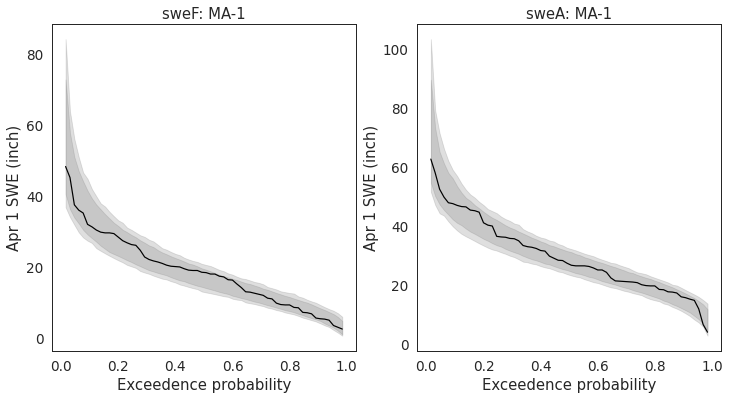

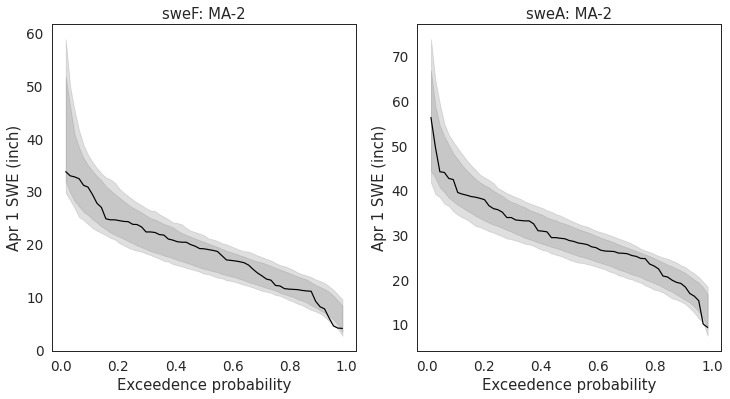

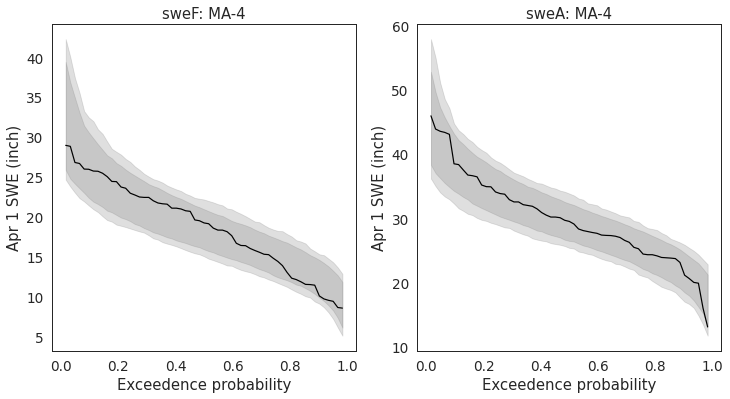

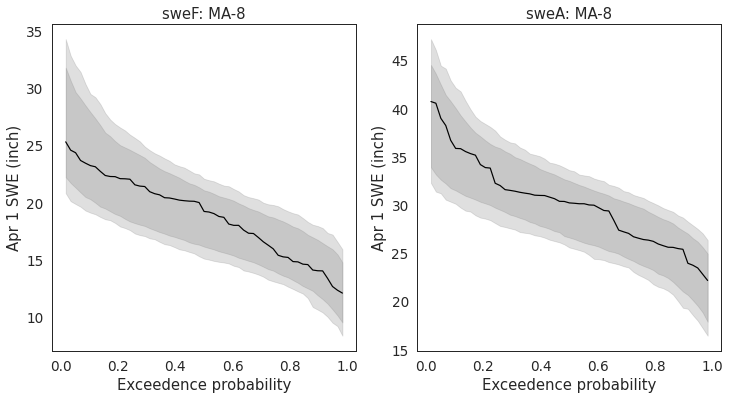

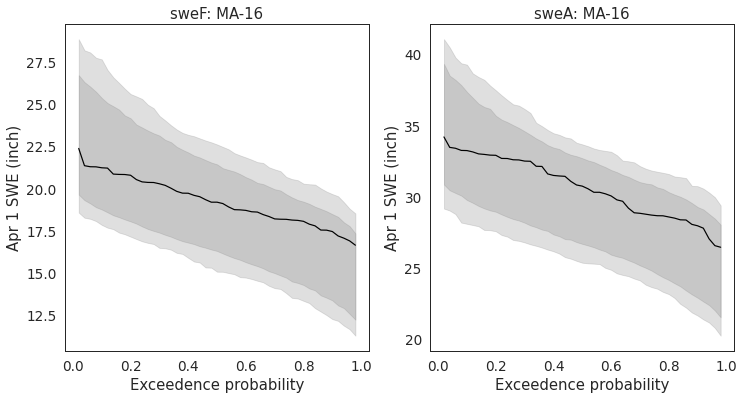

In [29]:
# print(exceedence[1]['synF'][0][nyr-1])
for ma in [1,2,4,8,16]:
    plt.figure(figsize=(12,6))
    for i,k in enumerate(['F', 'A']):
        ax = plt.subplot(1,2,i+1)
        q01, q05, q95, q99 = [], [], [], []
        for q in range(len(probs[ma])):
            q01.append(np.quantile([exceedence[ma]['syn'+k][i][q] for i in range(nsamp)], 0.01))
            q05.append(np.quantile([exceedence[ma]['syn'+k][i][q] for i in range(nsamp)], 0.05))
            q95.append(np.quantile([exceedence[ma]['syn'+k][i][q] for i in range(nsamp)], 0.95))
            q99.append(np.quantile([exceedence[ma]['syn'+k][i][q] for i in range(nsamp)], 0.99))
        plt.fill_between(probs[ma], q99, q01, color='0.5', alpha=0.25)
        plt.fill_between(probs[ma], q95, q05, color='0.5', alpha=0.25)        
        plt.plot(probs[ma], exceedence[ma]['obs'+k][0], c='k', alpha=1)
        plt.xlabel('Exceedence probability')
        plt.ylabel('Apr 1 SWE (inch)')
        plt.title('swe'+k+': MA-' + str(ma))

### Wavelet - Feb obs

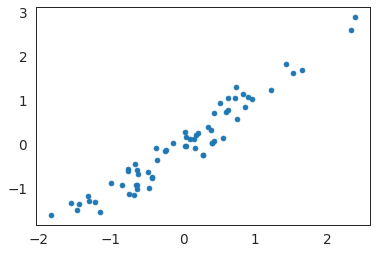

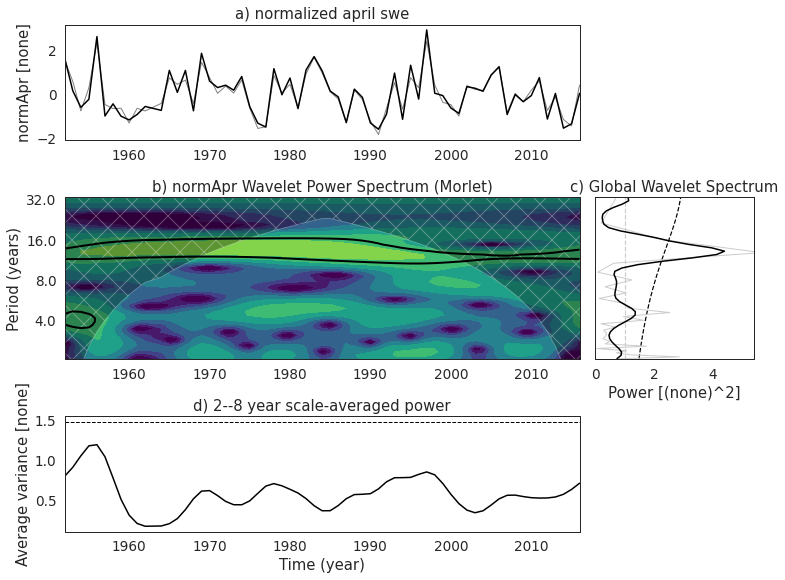

In [33]:
### Look at wavelet spectrum (adapted from http://regeirk.github.io/pycwt/pycwt.html)
from __future__ import division
import numpy
from matplotlib import pyplot
import pycwt as wavelet
from pycwt.helpers import find

dat = swe.danFeb.values
time = swe.index
title = 'normalized april swe'
label = 'normApr'
units = 'none'

# We also create a time array in years.
N = dat.size
t = time
t0 =time[0]
dt = 1  # In years

# # We write the following code to detrend and normalize the input data by its
# # standard deviation. Sometimes detrending is not necessary and simply
# # removing the mean value is good enough. However, if your dataset has a well
# # defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# # above mentioned website, it is strongly advised to perform detrending.
# # Here, we fit a one-degree polynomial function and then subtract it from the
# # original data.
# p = numpy.polyfit(t - t0, dat, 1)
# dat_notrend = dat - numpy.polyval(p, t - t0)
# std = dat_notrend.std()  # Standard deviation
# var = std ** 2  # Variance
# dat_norm = dat_notrend / std  # Normalized dataset
dat_norm = (dat - dat.mean()) / dat.std()
var = dat_norm.var()

# The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 4 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
alpha=0

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) #* std

# print(wave.shape)
# print(scales.shape)
# print(freqs.shape)
# print(iwave.shape)
# print(iwave.real/dat_norm)
fig = plt.figure()
plt.scatter(iwave.real, dat_norm)
plt.show()

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave.real, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()


### Wavelet - Apr obs

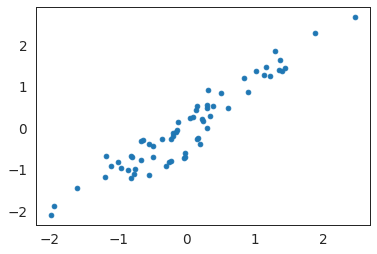

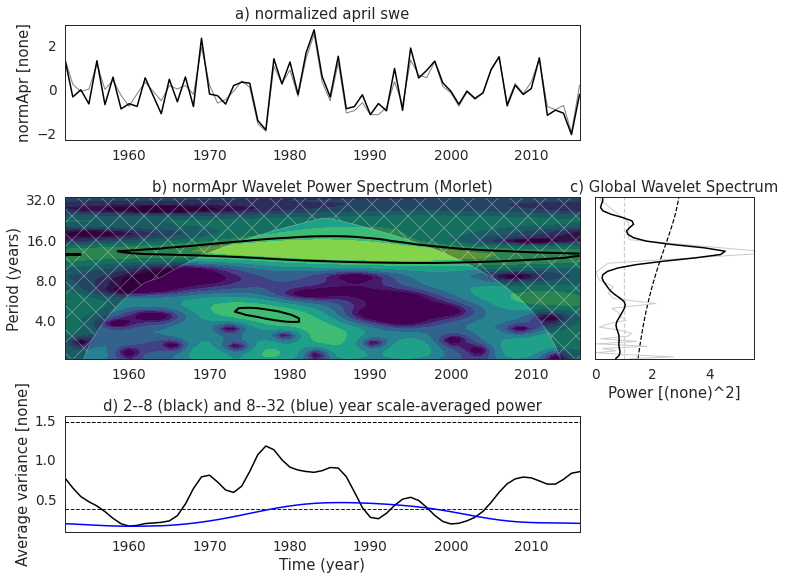

In [65]:
### Look at wavelet spectrum (adapted from http://regeirk.github.io/pycwt/pycwt.html)
from __future__ import division
import numpy
from matplotlib import pyplot
import pycwt as wavelet
from pycwt.helpers import find

dat = swe.danApr.values
time = swe.index
title = 'normalized april swe'
label = 'normApr'
units = 'none'

# We also create a time array in years.
N = dat.size
t = time
t0 =time[0]
dt = 1  # In years

# # We write the following code to detrend and normalize the input data by its
# # standard deviation. Sometimes detrending is not necessary and simply
# # removing the mean value is good enough. However, if your dataset has a well
# # defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# # above mentioned website, it is strongly advised to perform detrending.
# # Here, we fit a one-degree polynomial function and then subtract it from the
# # original data.
# p = numpy.polyfit(t - t0, dat, 1)
# dat_notrend = dat - numpy.polyval(p, t - t0)
# std = dat_notrend.std()  # Standard deviation
# var = std ** 2  # Variance
# dat_norm = dat_notrend / std  # Normalized dataset
dat_norm = (dat - dat.mean()) / dat.std()
var = dat_norm.var()

# The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 4 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
alpha=0

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) #* std

# print(wave.shape)
# print(scales.shape)
# print(freqs.shape)
# print(iwave.shape)
# print(iwave.real/dat_norm)
fig = plt.figure()
plt.scatter(iwave.real, dat_norm)
plt.show()

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
Cdelta = mother.cdelta

sel_2_8 = find((period >= 2) & (period <= 8))
scale_avg_2_8 = (scales * numpy.ones((N, 1))).transpose()
scale_avg_2_8 = power / scale_avg_2_8  # As in Torrence and Compo (1998) equation 24
scale_avg_2_8 = var * dj * dt / Cdelta * scale_avg_2_8[sel_2_8, :].sum(axis=0)
scale_avg_signif_2_8, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel_2_8[0]],
                                                  scales[sel_2_8[-1]]],
                                             wavelet=mother)
sel_8_32 = find((period > 8) & (period <= 32))
Cdelta = mother.cdelta
scale_avg_8_32 = (scales * numpy.ones((N, 1))).transpose()
scale_avg_8_32 = power / scale_avg_8_32  # As in Torrence and Compo (1998) equation 24
scale_avg_8_32 = var * dj * dt / Cdelta * scale_avg_8_32[sel_8_32, :].sum(axis=0)
scale_avg_signif_8_32, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel_8_32[0]],
                                                  scales[sel_8_32[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave.real, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif_2_8, color='k', linestyle='--', linewidth=1.)
dx.axhline(scale_avg_signif_8_32, color='b', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg_2_8, 'k-', linewidth=1.5)
dx.plot(t, scale_avg_8_32, 'b-', linewidth=1.5)
dx.set_title('d) {}--{} (black) and {}--{} (blue) year scale-averaged power'.format(2,8,8,32))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()


### Wavelet - Feb synthm

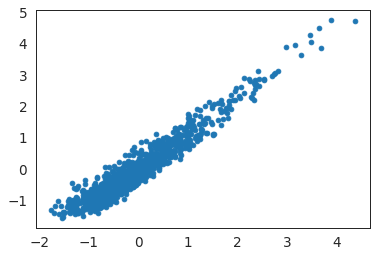

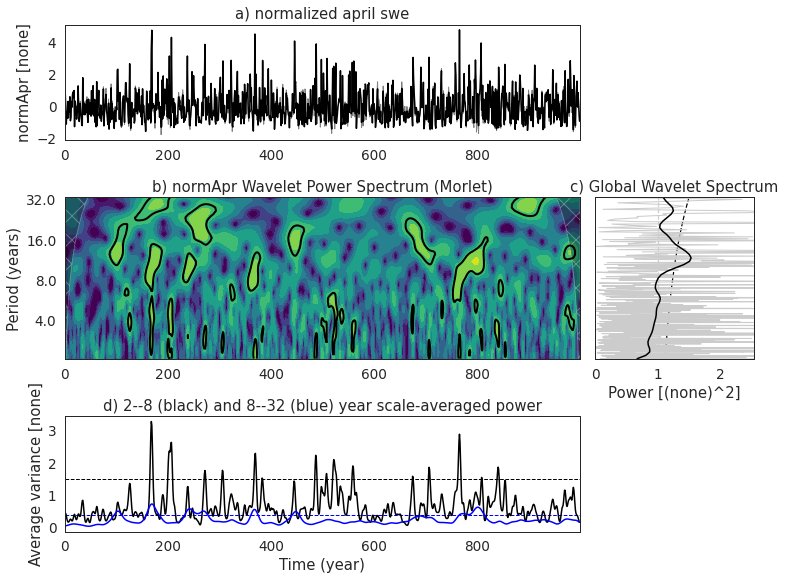

In [64]:
### Look at wavelet spectrum (adapted from http://regeirk.github.io/pycwt/pycwt.html)
from __future__ import division
import numpy
from matplotlib import pyplot
import pycwt as wavelet
from pycwt.helpers import find

dat = sweSynth.danFeb.values[:1000]
time = np.arange(len(dat))
title = 'normalized april swe'
label = 'normApr'
units = 'none'

# We also create a time array in years.
N = dat.size
t = time
t0 =time[0]
dt = 1  # In years

# # We write the following code to detrend and normalize the input data by its
# # standard deviation. Sometimes detrending is not necessary and simply
# # removing the mean value is good enough. However, if your dataset has a well
# # defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# # above mentioned website, it is strongly advised to perform detrending.
# # Here, we fit a one-degree polynomial function and then subtract it from the
# # original data.
# p = numpy.polyfit(t - t0, dat, 1)
# dat_notrend = dat - numpy.polyval(p, t - t0)
# std = dat_notrend.std()  # Standard deviation
# var = std ** 2  # Variance
# dat_norm = dat_notrend / std  # Normalized dataset
dat_norm = (dat - dat.mean()) / dat.std()
var = dat_norm.var()

# The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 4 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
alpha=0

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) #* std

# print(wave.shape)
# print(scales.shape)
# print(freqs.shape)
# print(iwave.shape)
# print(iwave.real/dat_norm)
fig = plt.figure()
plt.scatter(iwave.real, dat_norm)
plt.show()

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
Cdelta = mother.cdelta

sel_2_8 = find((period >= 2) & (period <= 8))
scale_avg_2_8 = (scales * numpy.ones((N, 1))).transpose()
scale_avg_2_8 = power / scale_avg_2_8  # As in Torrence and Compo (1998) equation 24
scale_avg_2_8 = var * dj * dt / Cdelta * scale_avg_2_8[sel_2_8, :].sum(axis=0)
scale_avg_signif_2_8, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel_2_8[0]],
                                                  scales[sel_2_8[-1]]],
                                             wavelet=mother)
sel_8_32 = find((period > 8) & (period <= 32))
Cdelta = mother.cdelta
scale_avg_8_32 = (scales * numpy.ones((N, 1))).transpose()
scale_avg_8_32 = power / scale_avg_8_32  # As in Torrence and Compo (1998) equation 24
scale_avg_8_32 = var * dj * dt / Cdelta * scale_avg_8_32[sel_8_32, :].sum(axis=0)
scale_avg_signif_8_32, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel_8_32[0]],
                                                  scales[sel_8_32[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave.real, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif_2_8, color='k', linestyle='--', linewidth=1.)
dx.axhline(scale_avg_signif_8_32, color='b', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg_2_8, 'k-', linewidth=1.5)
dx.plot(t, scale_avg_8_32, 'b-', linewidth=1.5)
dx.set_title('d) {}--{} (black) and {}--{} (blue) year scale-averaged power'.format(2,8,8,32))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()


### Wavelet - Apr synth

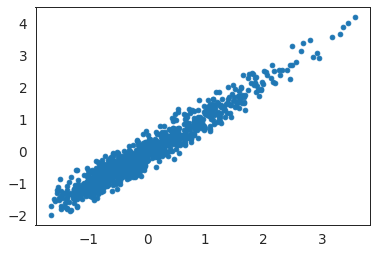

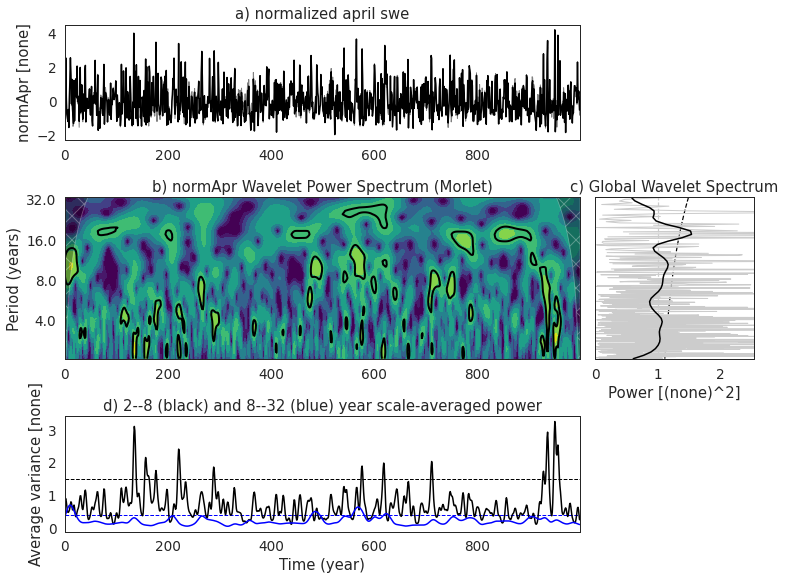

In [63]:
### Look at wavelet spectrum (adapted from http://regeirk.github.io/pycwt/pycwt.html)
from __future__ import division
import numpy
from matplotlib import pyplot
import pycwt as wavelet
from pycwt.helpers import find

dat = sweSynth.danApr.values[1000:2000]
time = np.arange(len(dat))
title = 'normalized april swe'
label = 'normApr'
units = 'none'

# We also create a time array in years.
N = dat.size
t = time
t0 =time[0]
dt = 1  # In years

# # We write the following code to detrend and normalize the input data by its
# # standard deviation. Sometimes detrending is not necessary and simply
# # removing the mean value is good enough. However, if your dataset has a well
# # defined trend, such as the Mauna Loa CO\ :sub:`2` dataset available in the
# # above mentioned website, it is strongly advised to perform detrending.
# # Here, we fit a one-degree polynomial function and then subtract it from the
# # original data.
# p = numpy.polyfit(t - t0, dat, 1)
# dat_notrend = dat - numpy.polyval(p, t - t0)
# std = dat_notrend.std()  # Standard deviation
# var = std ** 2  # Variance
# dat_norm = dat_notrend / std  # Normalized dataset
dat_norm = (dat - dat.mean()) / dat.std()
var = dat_norm.var()

# The next step is to define some parameters of our wavelet analysis. We
# select the mother wavelet, in this case the Morlet wavelet with
# :math:`\omega_0=6`.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 4 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
alpha=0

# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) #* std

# print(wave.shape)
# print(scales.shape)
# print(freqs.shape)
# print(iwave.shape)
# print(iwave.real/dat_norm)
fig = plt.figure()
plt.scatter(iwave.real, dat_norm)
plt.show()

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
Cdelta = mother.cdelta

sel_2_8 = find((period >= 2) & (period <= 8))
scale_avg_2_8 = (scales * numpy.ones((N, 1))).transpose()
scale_avg_2_8 = power / scale_avg_2_8  # As in Torrence and Compo (1998) equation 24
scale_avg_2_8 = var * dj * dt / Cdelta * scale_avg_2_8[sel_2_8, :].sum(axis=0)
scale_avg_signif_2_8, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel_2_8[0]],
                                                  scales[sel_2_8[-1]]],
                                             wavelet=mother)
sel_8_32 = find((period > 8) & (period <= 32))
Cdelta = mother.cdelta
scale_avg_8_32 = (scales * numpy.ones((N, 1))).transpose()
scale_avg_8_32 = power / scale_avg_8_32  # As in Torrence and Compo (1998) equation 24
scale_avg_8_32 = var * dj * dt / Cdelta * scale_avg_8_32[sel_8_32, :].sum(axis=0)
scale_avg_signif_8_32, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel_8_32[0]],
                                                  scales[sel_8_32[-1]]],
                                             wavelet=mother)

# Finally, we plot our results in four different subplots containing the
# (i) original series anomaly and the inverse wavelet transform; (ii) the
# wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
# (iv) the range averaged wavelet spectrum. In all sub-plots the significance
# levels are either included as dotted lines or as filled contour lines.

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave.real, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif_2_8, color='k', linestyle='--', linewidth=1.)
dx.axhline(scale_avg_signif_8_32, color='b', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg_2_8, 'k-', linewidth=1.5)
dx.plot(t, scale_avg_8_32, 'b-', linewidth=1.5)
dx.set_title('d) {}--{} (black) and {}--{} (blue) year scale-averaged power'.format(2,8,8,32))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()
